                                    Variable  Num_NaNs  Porcentaje
Event Site                        Event Site      1068       90.20
Event                                  Event      1062       89.70
Subtype                              Subtype       212       17.91
Survival Time (years)  Survival Time (years)        32        2.70


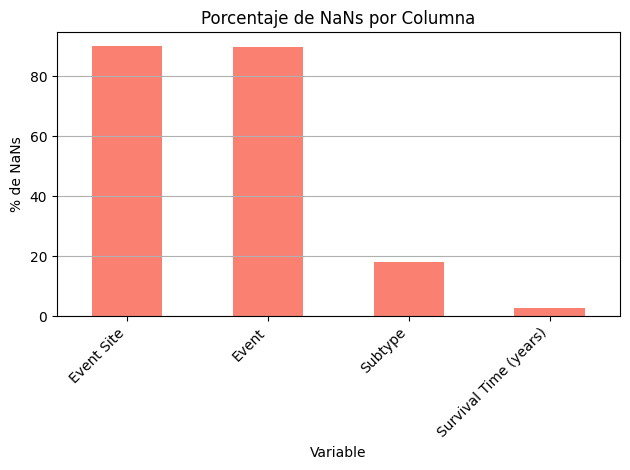

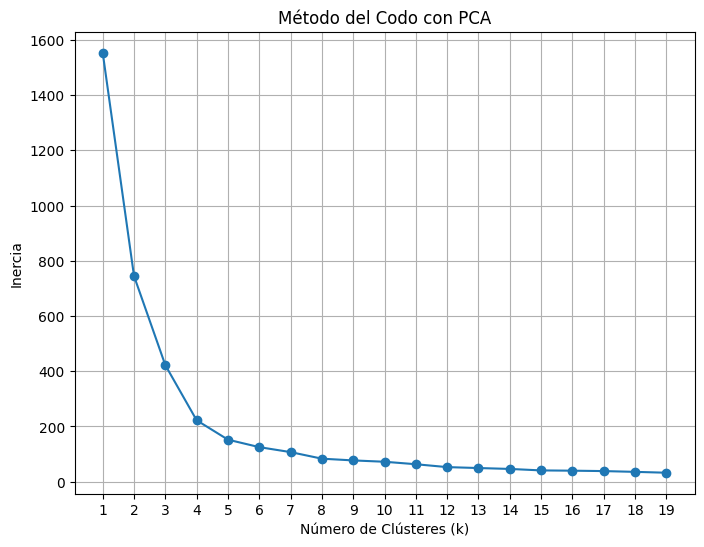

Seed 10 → Silhouette Score: 0.638
Seed 20 → Silhouette Score: 0.638
Seed 30 → Silhouette Score: 0.638
Seed 40 → Silhouette Score: 0.638
Seed 50 → Silhouette Score: 0.545
Seed 60 → Silhouette Score: 0.638
Seed 70 → Silhouette Score: 0.637
Seed 80 → Silhouette Score: 0.638
Seed 90 → Silhouette Score: 0.637
Seed 100 → Silhouette Score: 0.545

🔍 Mejor Seed: 10 con Silhouette Score: 0.638


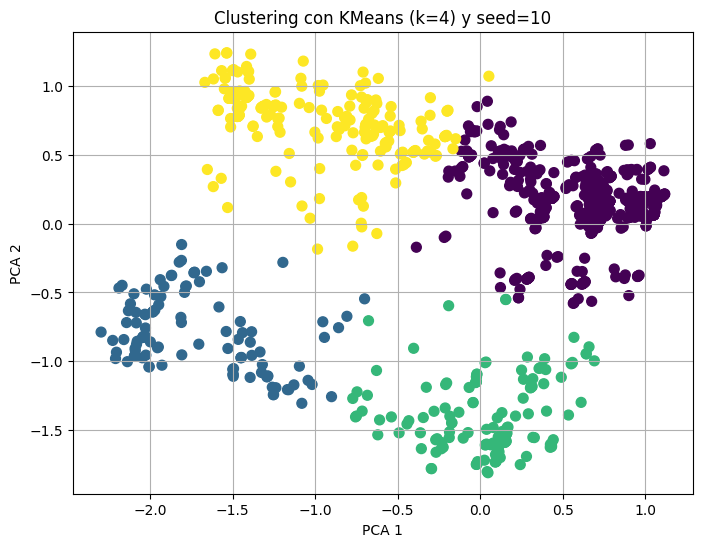

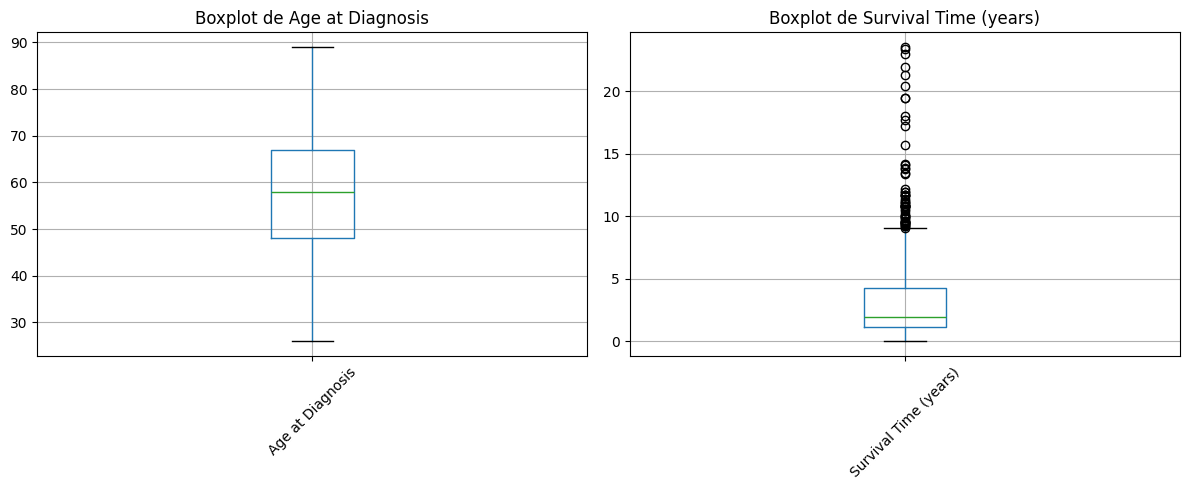

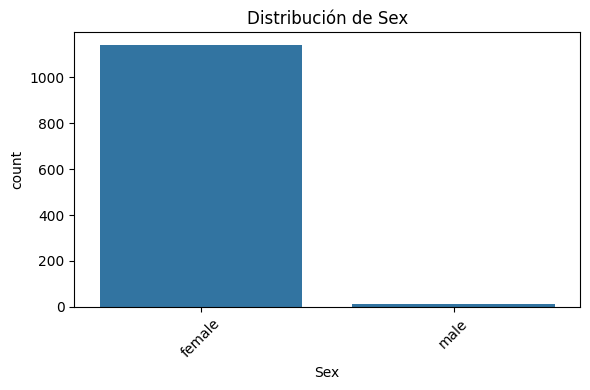

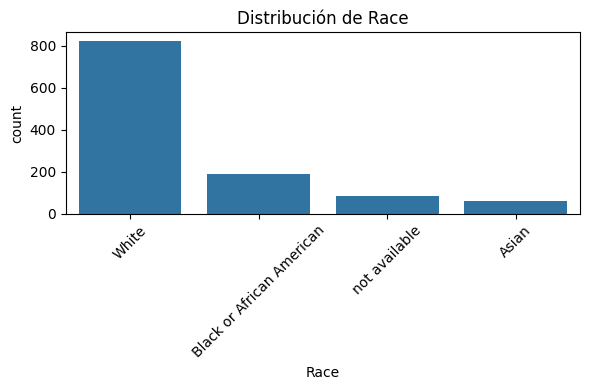

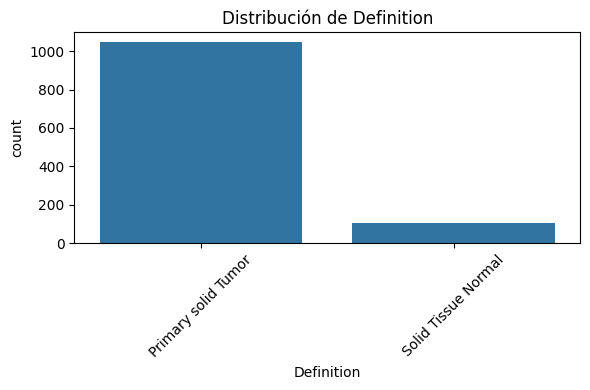

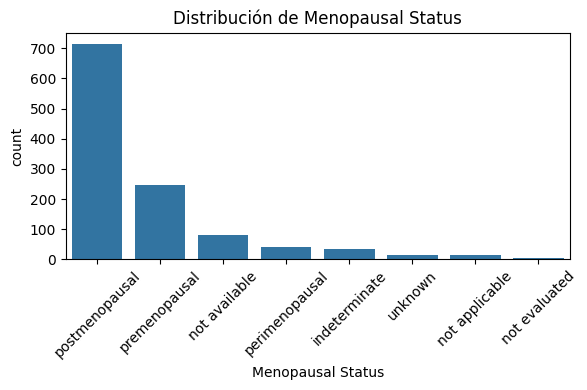

<ipython-input-1-11395a5cebf5>:146: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


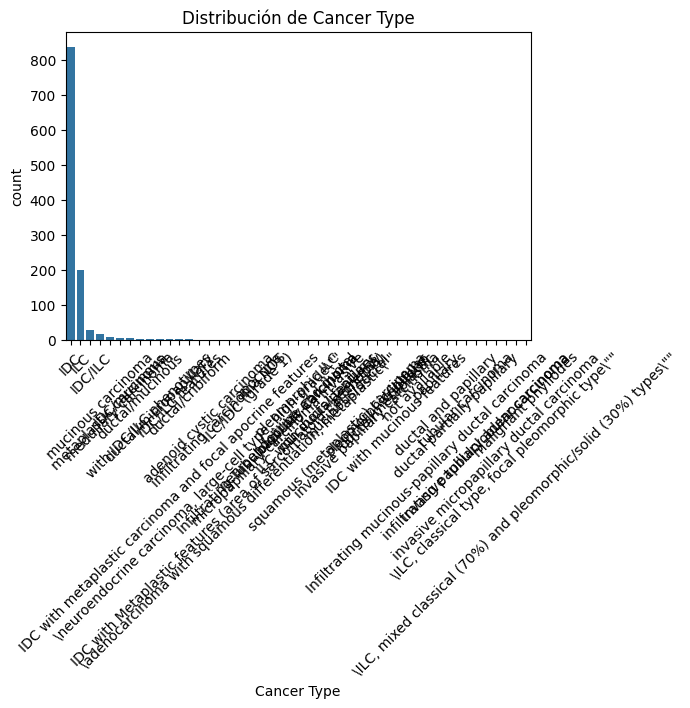

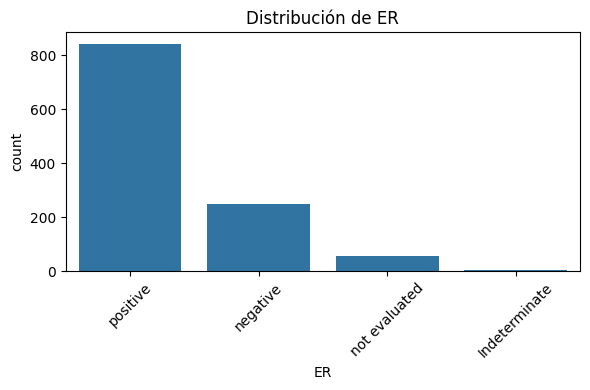

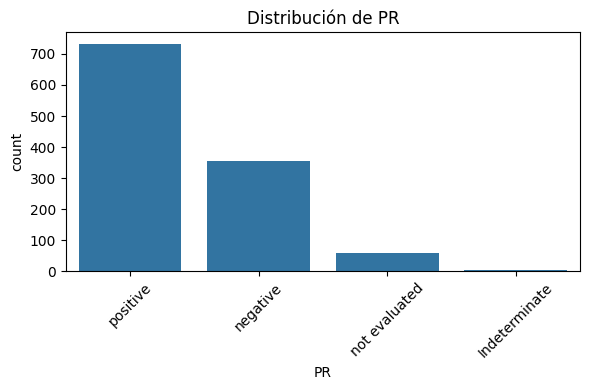

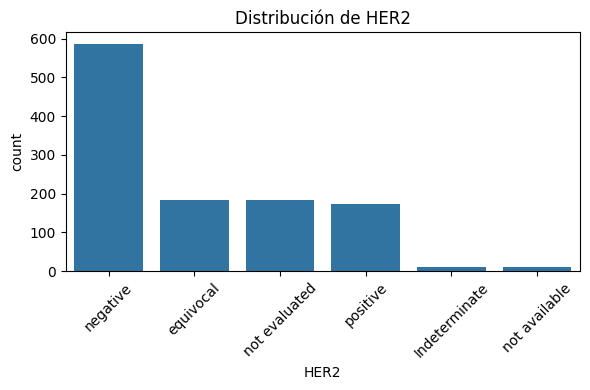

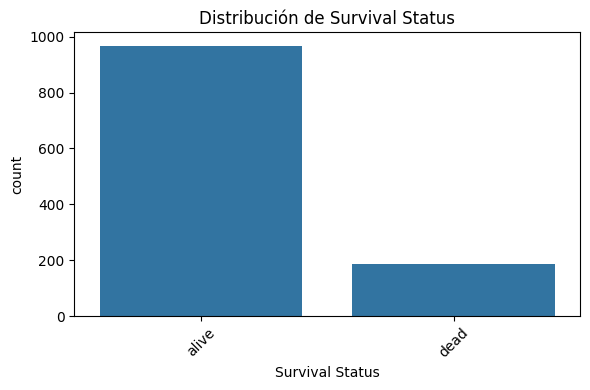

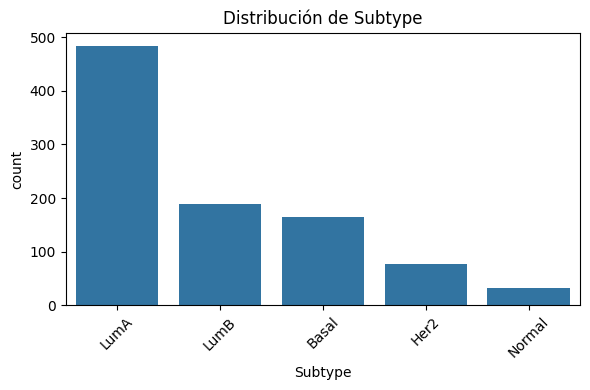

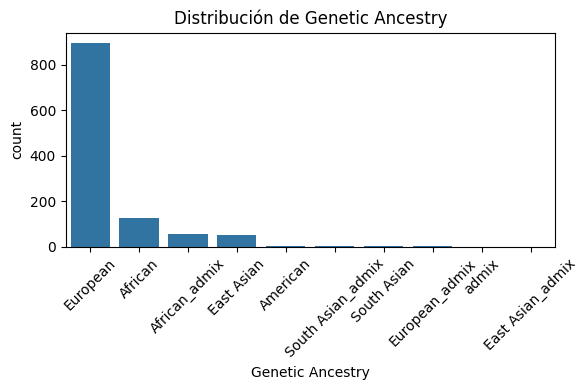

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Cargar datos
data = pd.read_excel('MetaData.xlsx')
df = pd.DataFrame(data)

# Supongamos que tu DataFrame se llama df

na_summary = pd.DataFrame({
    'Variable': df.columns,
    'Num_NaNs': df.isna().sum(),
    'Porcentaje': (df.isna().mean() * 100).round(2)
})

# Filtrar solo columnas con al menos un NaN
na_summary = na_summary[na_summary['Num_NaNs'] > 0]

# Ordenar de mayor a menor porcentaje
na_summary = na_summary.sort_values(by='Porcentaje', ascending=False)

print(na_summary)

import matplotlib.pyplot as plt

na_summary.plot(kind='bar', x='Variable', y='Porcentaje', legend=False, color='salmon')
plt.title("Porcentaje de NaNs por Columna")
plt.ylabel("% de NaNs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Eliminar columnas irrelevantes (IDs y duplicadas)
df = df.drop(df.columns[[0, -1, 10, 11]], axis=1)

# Eliminar filas con NaN en 'Survival Time (years)'
df = df.dropna(subset=['Survival Time (years)'])

# Variables
numeric_vars = ['Age at Diagnosis', 'Survival Time (years)']
categorical_vars = ['Sex', 'Race', 'Definition', 'Menopausal Status', 'Cancer Type',
                    'ER', 'PR', 'HER2', 'Survival Status',
                    'Subtype', 'Genetic Ancestry']

# Pipelines de transformación
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Composición del preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_vars),
    ('cat', categorical_transformer, categorical_vars)
])

# Aplicar el preprocesamiento
X_processed = preprocessor.fit_transform(df)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Método del codo para determinar k óptimo
inertia = []
k_range = range(1, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title("Método del Codo con PCA")
plt.xlabel("Número de Clústeres (k)")
plt.ylabel("Inercia")
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Definir el número óptimo de clústeres (ajusta según el codo visual)
optimal_k = 4

# Buscar la mejor semilla para KMeans según Silhouette Score
best_score = -1
best_seed = None
best_labels = None

for seed in range(10, 110, 10):
    kmeans = KMeans(n_clusters=optimal_k, random_state=seed)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print(f"Seed {seed} → Silhouette Score: {score:.3f}")

    if score > best_score:
        best_score = score
        best_seed = seed
        best_labels = labels

print(f"\n🔍 Mejor Seed: {best_seed} con Silhouette Score: {best_score:.3f}")

# Visualización final del clustering
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', s=50)
plt.title(f"Clustering con KMeans (k={optimal_k}) y seed={best_seed}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# 🎯 Exploración inicial: Diagramas de caja para variables numéricas
plt.figure(figsize=(12, 5))

for i, col in enumerate(numeric_vars):
    plt.subplot(1, len(numeric_vars), i+1)
    df.boxplot(column=col)
    plt.title(f'Boxplot de {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 🔢 Distribución de variables categóricas
import seaborn as sns

for col in categorical_vars:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

KeyError: 'Cluster'